In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# load python functions and modules
import funcs
import mrsobs

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# set user directories
workDir  = '/Users/ioannisa/Desktop/python/miri_devel/'
lvl1path = '/Volumes/miri_mrs_data/FM_MRS/'
lvl2path = workDir+'FM_data/LVL2/'
cdpDir   = workDir+'cdp_data/'
d2cMapDir = workDir+'notebooks/distortionMaps/'

**Let's load the LVL1 data**

In [9]:
# Get data
sci_exp_filename,ignore_bkg   = mrsobs.FM_MTS_BB_extended_source(lvl1path,'1A',bb_temp='800K',output='filename')
sci_exp_hdu   = fits.open(sci_exp_filename.replace('_LVL2',''))
sci_exp_ramp  = (sci_exp_hdu[0].data).astype('float')

#-- print header 
# print(repr(sci_exp_hdu[0].header))
# print sci_exp_hdu[1].data[:25]

In [10]:
# From MIRI-TR-00008-UA-RSCD:
# An initial charge is placed on the detector node capacitance through the Vdduc supply when the reset switch is closed. 
# The detector bias voltage is set by the difference between Vdetcom (applied to the transparent buried contact) and Vdduc 
# (applied to the indium bump contact). There is an additional ~0.2 Volt placed on the node from charge injection so that 
# the final applied bias voltage is (Vdduc + 0.2V) – Vdetcom.
VDDUC,VDETCOM,VSSOUT = [[] for j in range(3)]
for i in range(len(sci_exp_hdu[1].data)):
    if sci_exp_hdu[1].data[i][1] in ['IGDP_MIR_SW_V_VDDUC','IGDP_MIR_LW_V_VDDUC']:
        VDDUC.append(float(sci_exp_hdu[1].data[i][2]))
    elif sci_exp_hdu[1].data[i][1] in ['IGDP_MIR_SW_V_VDETCOM','IGDP_MIR_LW_V_VDETCOM']:
        VDETCOM.append(float(sci_exp_hdu[1].data[i][2]))
    elif sci_exp_hdu[1].data[i][1] in ['IGDP_MIR_SW_V_VSSOUT','IGDP_MIR_LW_V_VSSOUT']:
        VSSOUT.append(float(sci_exp_hdu[1].data[i][2]))
VDDUC,VDETCOM,VSSOUT = np.array(VDDUC),np.array(VDETCOM),np.array(VSSOUT)

VBIAS = (VDDUC+0.2)-VDETCOM

<IPython.core.display.Javascript object>


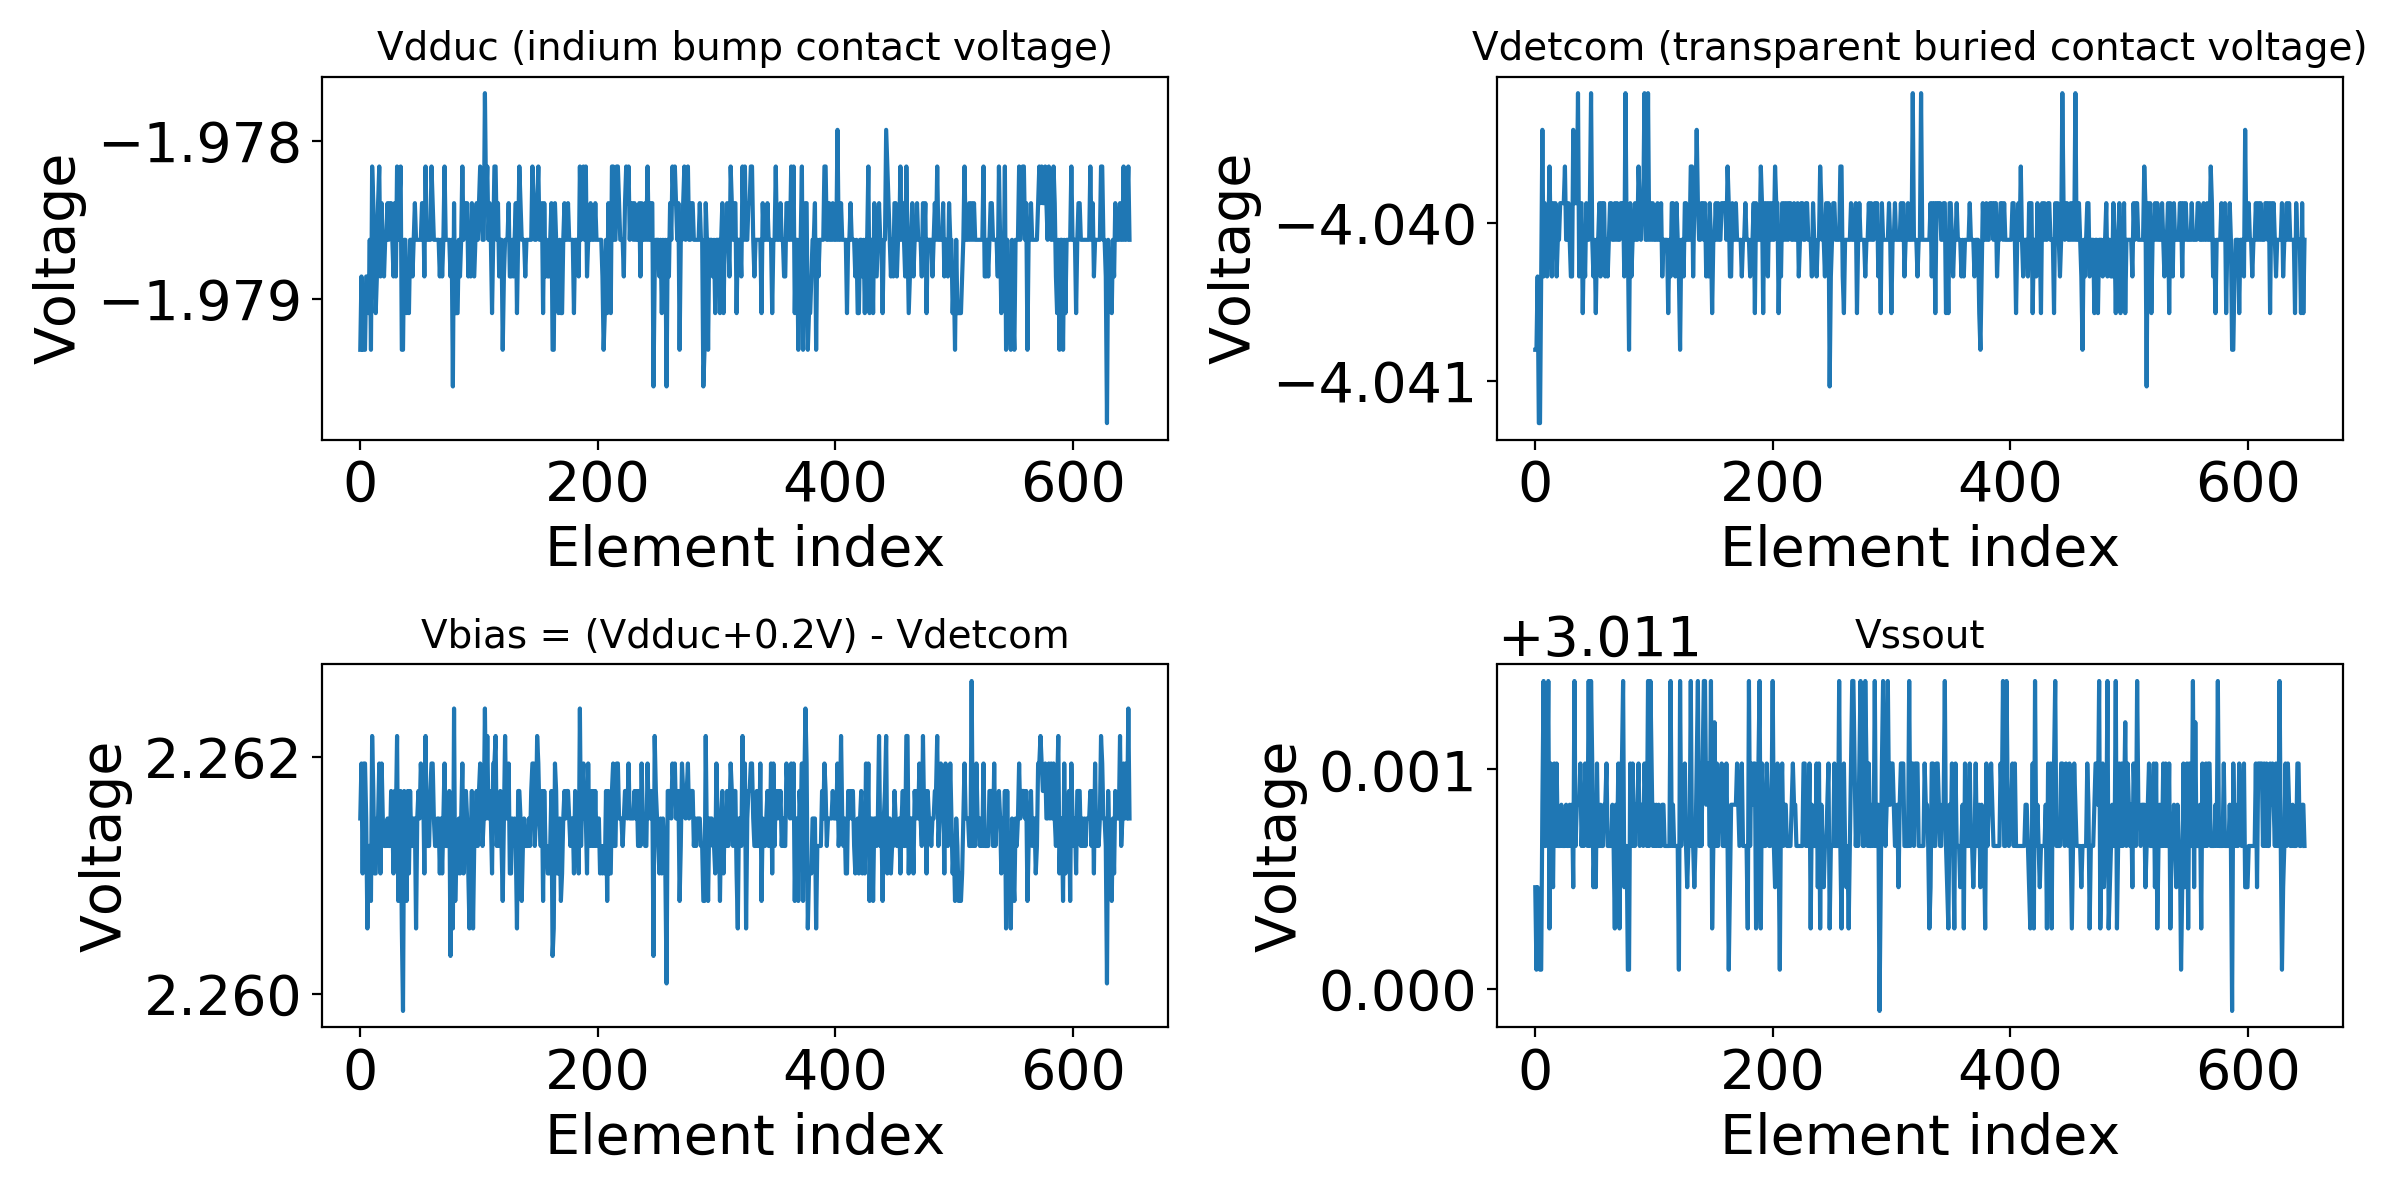

In [11]:
fig,axs = plt.subplots(2,2,figsize=(12,6))
axs[0,0].plot(VDDUC)
axs[0,0].set_xlabel('Element index')
axs[0,0].set_ylabel('Voltage')
axs[0,0].set_title('Vdduc (indium bump contact voltage)',fontsize=14)
axs[0,1].plot(VDETCOM)
axs[0,1].set_xlabel('Element index')
axs[0,1].set_ylabel('Voltage')
axs[0,1].set_title('Vdetcom (transparent buried contact voltage)',fontsize=14)
axs[1,0].plot(VBIAS)
axs[1,0].set_xlabel('Element index')
axs[1,0].set_ylabel('Voltage')
axs[1,0].set_title('Vbias = (Vdduc+0.2V) - Vdetcom',fontsize=14)
axs[1,1].plot(VSSOUT)
axs[1,1].set_xlabel('Element index')
axs[1,1].set_ylabel('Voltage')
axs[1,1].set_title('Vssout',fontsize=14)
plt.tight_layout()

In [12]:
nints = sci_exp_hdu[0].header['NINT']
ngroups = sci_exp_hdu[0].header['NGROUP']
frame_delta_time = sci_exp_hdu[0].header['TFRAME']
print('Number of integrations: {}'.format(nints))
print('Number of groups/frames per integration: {}'.format(ngroups))
print('LVL1 data shape: {}'.format(sci_exp_ramp.shape))

Number of integrations: 6
Number of groups/frames per integration: 20
LVL1 data shape: (120, 1280, 1032)


**Plot MIRI ramp image**

<IPython.core.display.Javascript object>


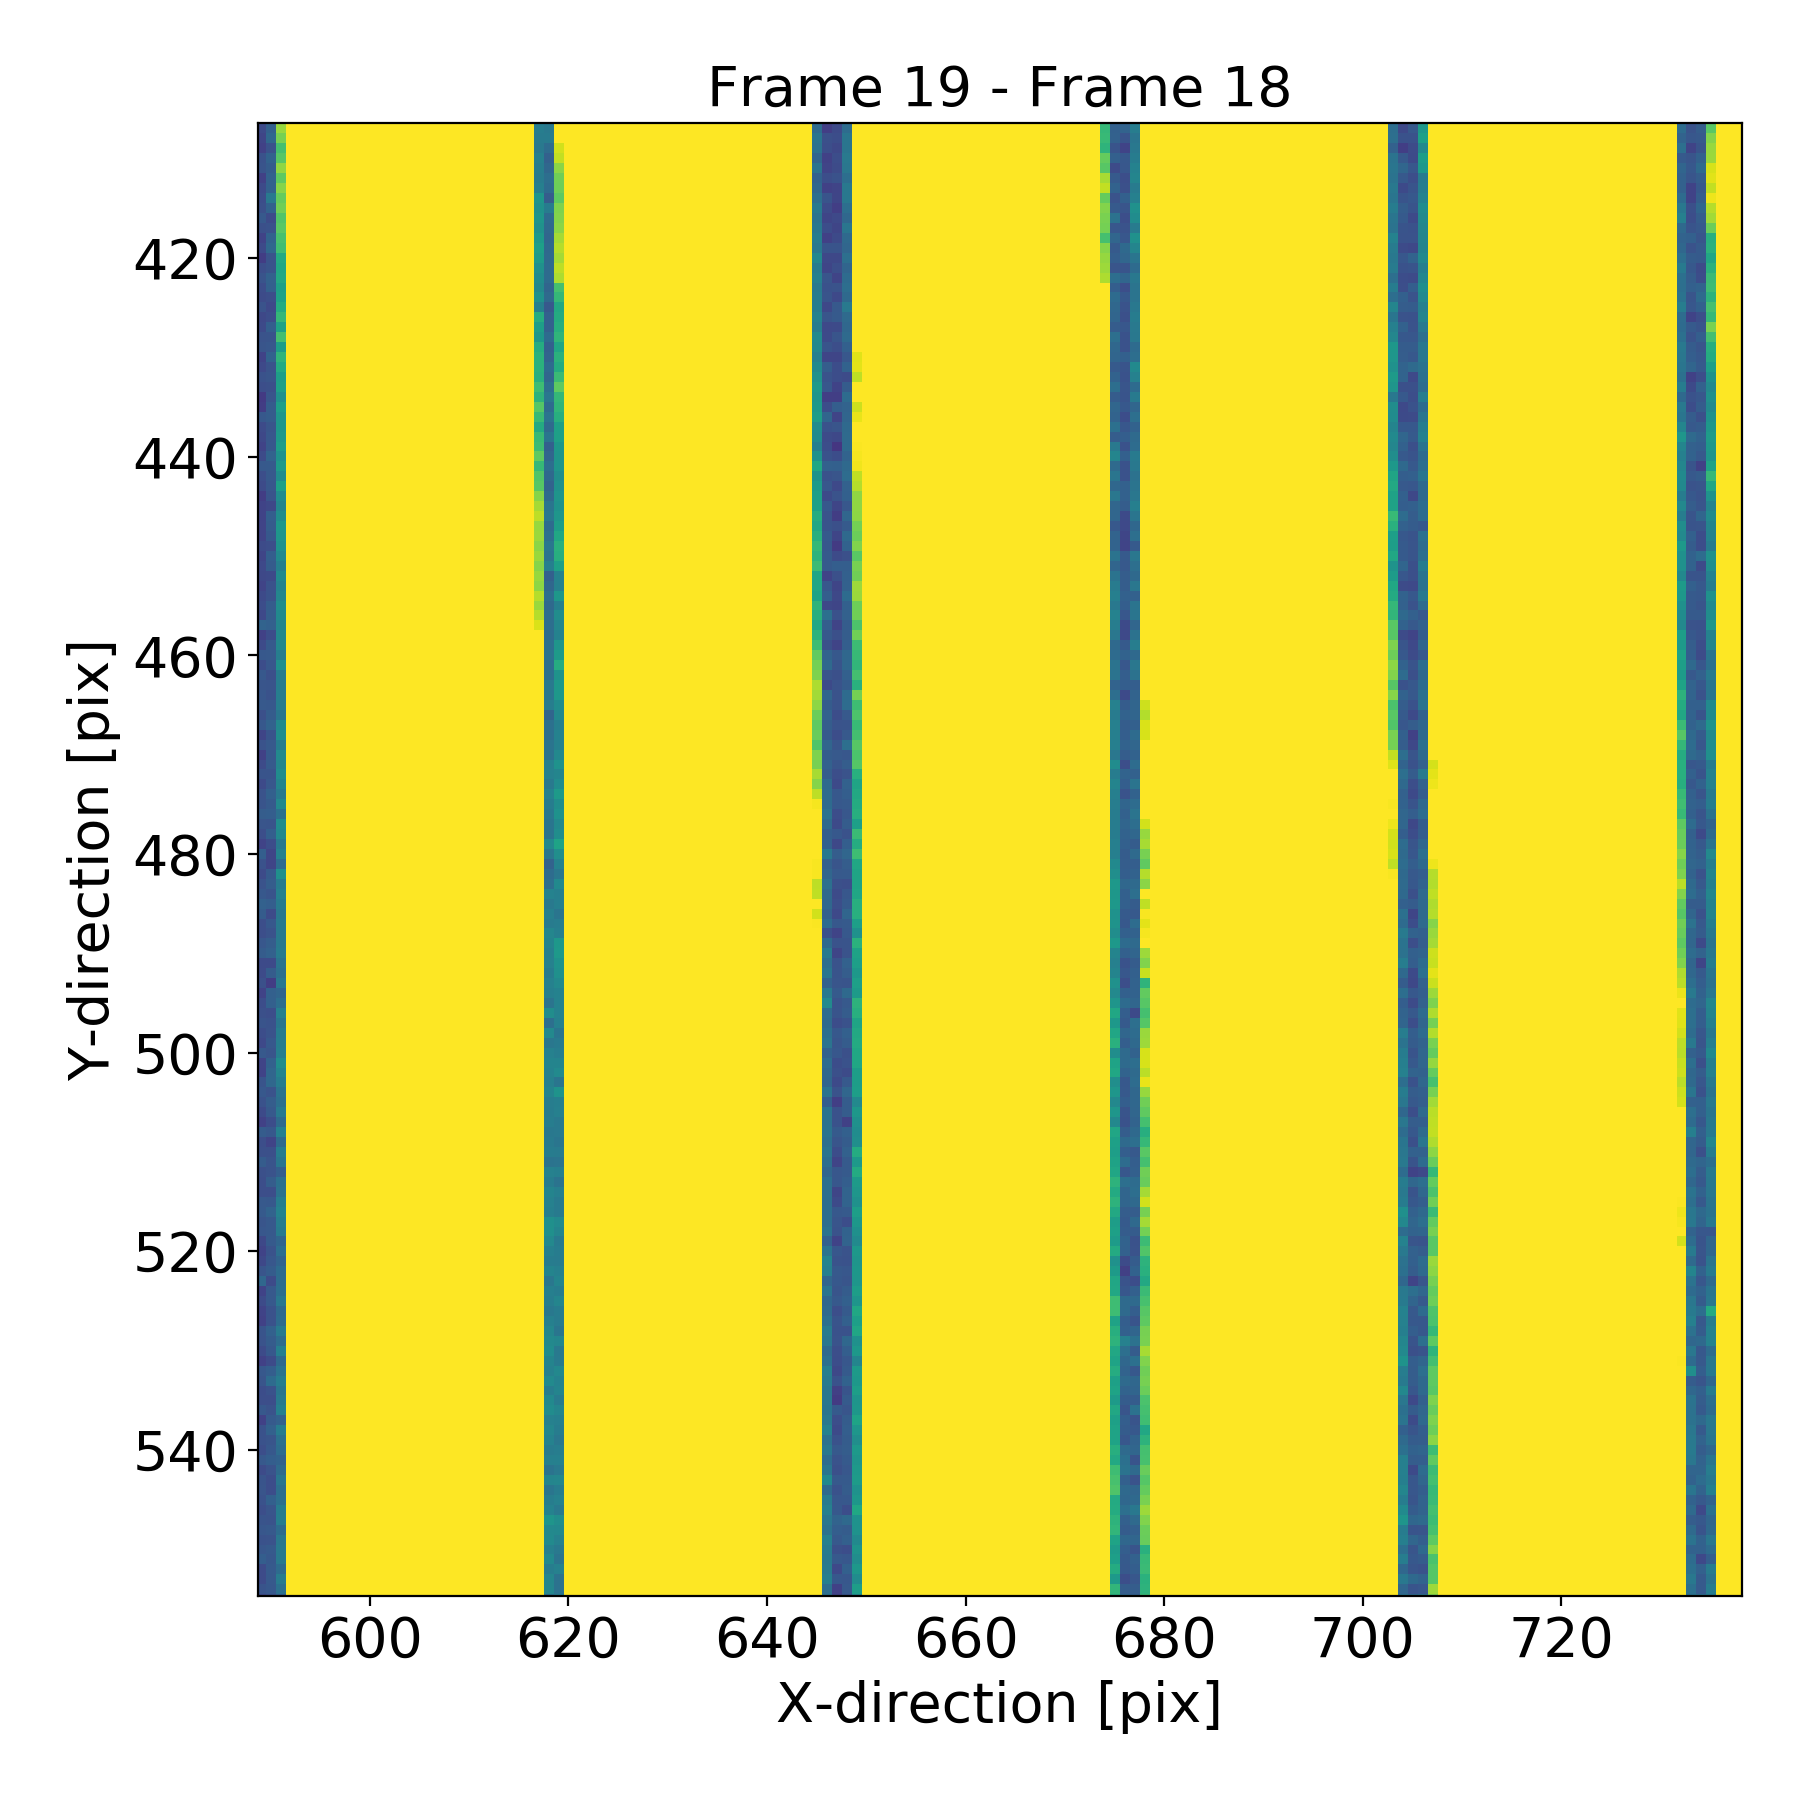

In [15]:
plt.figure(figsize=(9,9))
plt.title('Frame {} - Frame {}'.format(ngroups-1,ngroups-2))
plt.imshow(sci_exp_ramp[ngroups-2,:1024,:]-sci_exp_ramp[ngroups-3,:1024,:],vmin=0,vmax=200)
plt.xlabel('X-direction [pix]')
plt.ylabel('Y-direction [pix]')
plt.tight_layout()

# d2cMaps   = funcs.load_obj('d2cMaps_band{}_tr10pc'.format('2A'),path=d2cMapDir)
# ypos,xpos = funcs.detpixel_trace('2A',d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0.)
# # ypos,xpos = np.arange(1024), (np.ones(1024)*120).astype(int)

# plt.figure(figsize=(12,5))
# plt.step(np.arange(len(ypos)),(sci_exp_ramp[ngroups-2,ypos,xpos]-sci_exp_ramp[ngroups-3,ypos,xpos]),zorder=0,label='FRAME {}-FRAME {}'.format(ngroups-2,ngroups-3))
# plt.step(sci_exp_ramp[ngroups-1,ypos,xpos]-sci_exp_ramp[ngroups-2,ypos,xpos],'r',zorder=0,label='FRAME {}-FRAME {}'.format(ngroups-1,ngroups-2))
# sel = (sci_exp_ramp[ngroups-1,ypos,xpos]-sci_exp_ramp[ngroups-2,ypos,xpos])<0
# plt.step(np.arange(len(ypos))[sel],(sci_exp_ramp[ngroups-1,ypos,xpos]-sci_exp_ramp[ngroups-2,ypos,xpos])[sel],'k')
# sel = (sci_exp_ramp[ngroups-1,ypos,xpos]-sci_exp_ramp[ngroups-2,ypos,xpos])>0
# plt.step(np.arange(len(ypos))[sel],(sci_exp_ramp[ngroups-1,ypos,xpos]-sci_exp_ramp[ngroups-2,ypos,xpos])[sel],'k')
# plt.hlines(0,0,1024,'k',linestyle='dashed',zorder=1)
# plt.legend(loc='upper left',fontsize=10)
# plt.xlabel('X-direction [pix]')
# plt.ylabel('Difference [DN]')
# plt.tight_layout()

**Let's look at the integration ramps for one pixel**

<IPython.core.display.Javascript object>


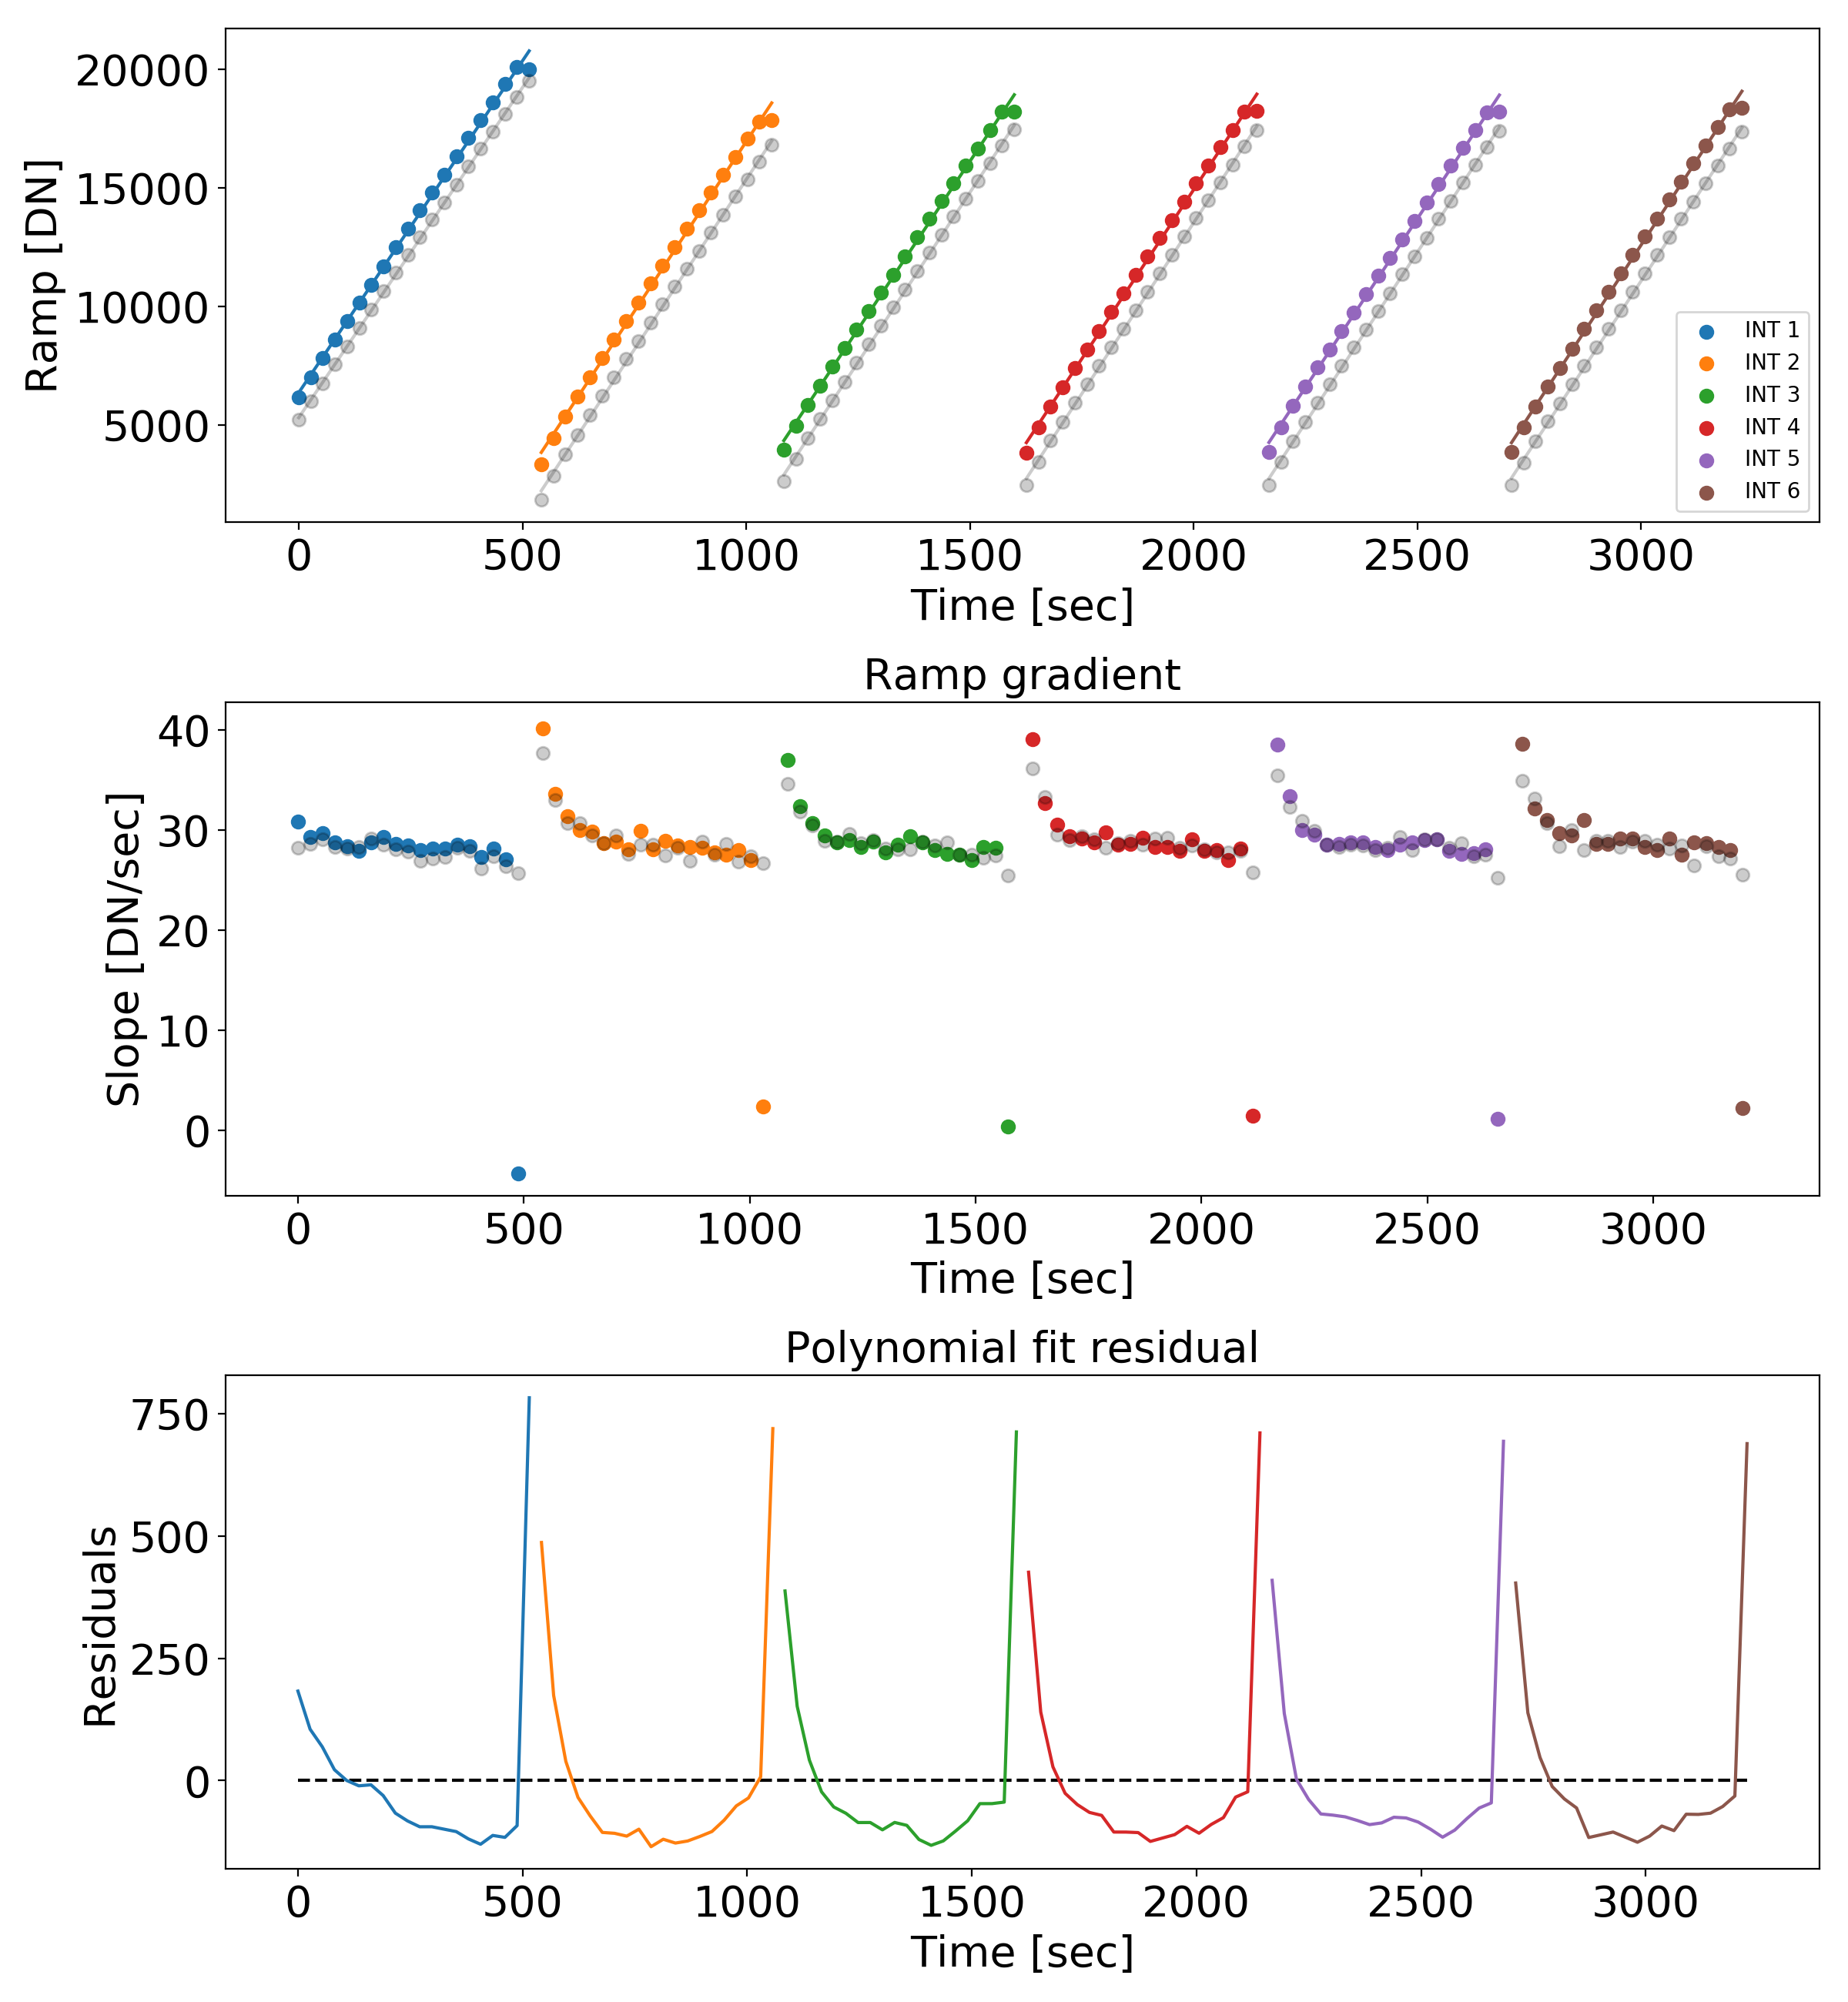

Determined slopes per integration: [27.97, 28.6, 28.3, 28.52, 28.43, 28.76] DN/sec
Determined slopes per integration (excluding last frame): [28.47, 29.07, 28.76, 28.98, 28.88, 29.21] DN/sec


In [17]:
ypos,xpos = 178,27
fig,axs = plt.subplots(3,1,figsize=(12,13))
slopes,slopes_minus_last_frame = [],[]
for i in range(nints):
    xdata  = np.arange(sci_exp_ramp.shape[0])[i*ngroups:(i+1)*ngroups]*frame_delta_time
    ydata  = sci_exp_ramp[i*ngroups:(i+1)*ngroups,ypos,xpos]
    
    xdata2  = np.arange(sci_exp_ramp.shape[0])[i*ngroups:(i+1)*ngroups]*frame_delta_time
    ydata2  = sci_exp_ramp[i*ngroups:(i+1)*ngroups,ypos-1,xpos]
    n_poly = 1
    
    popt = np.polyfit(xdata,ydata,n_poly)
    popt_minus_last_frame = np.polyfit(xdata[:-1],ydata[:-1],n_poly)
    poly = np.poly1d(popt)
    
    popt2 = np.polyfit(xdata2,ydata2,n_poly)
    poly2 = np.poly1d(popt2)
    
    slopes.append(round(popt[0],2))
    slopes_minus_last_frame.append(round(popt_minus_last_frame[0],2))
    
    residuals = poly(xdata)-ydata

    axs[0].plot(xdata,poly(xdata))
    axs[0].scatter(xdata,ydata,label='INT {}'.format(i+1))
    axs[0].plot(xdata2,poly2(xdata2),'k',alpha=0.2)
    axs[0].plot(xdata2,ydata2,'ko',alpha=0.2)
    axs[0].set_xlabel('Time [sec]')
    axs[0].set_ylabel('Ramp [DN]')
    axs[0].legend(loc='lower right',fontsize=10)
    axs[1].set_title('Ramp gradient')
    axs[1].scatter(xdata[:-1],np.diff(ydata)/frame_delta_time)
    axs[1].plot(xdata2[:-1],np.diff(ydata2)/frame_delta_time,'ko',alpha=0.2)
    axs[1].set_xlabel('Time [sec]')
    axs[1].set_ylabel('Slope [DN/sec]')
    axs[2].plot(xdata,residuals)
    axs[2].set_title('Polynomial fit residual')
    axs[2].set_xlabel('Time [sec]')
    axs[2].set_ylabel('Residuals')
axs[2].hlines(0,0,xdata[-1],linestyle='dashed')
plt.tight_layout()

print ('Determined slopes per integration: {} DN/sec'.format(slopes))
print ('Determined slopes per integration (excluding last frame): {} DN/sec'.format(slopes_minus_last_frame))

**Let's correct for the reset-switch-charge-decay (dummy correction)**

In [7]:
rscdCorrection = fits.open(cdpDir+'MIRI_FM_MIRIFUSHORT_12_RSCD_06.00.00.fits')[1].data
print('RSCD parameters: \n{}'.format(rscdCorrection))

tau = rscdCorrection[0][3]   # e-folding time scale (in units of seconds)
scale_factor = rscdCorrection[0][4]

sci_exp_ramp   = sci_exp_ramp[:,:1024,:] # ommit non-sensitive pixels
sci_exp_ramp_rscdCorr = np.full(sci_exp_ramp.shape,0.)
sci_exp_ramp_rscdCorr[:ngroups,:,:] = sci_exp_ramp[:ngroups,:,:]
for i in range(1,nints):
    # time since the last frame in the previous integration (units seconds)
    T = (np.arange(sci_exp_ramp.shape[0])[i*ngroups:(i+1)*ngroups]*frame_delta_time-np.arange(sci_exp_ramp.shape[0])[i*ngroups:(i+1)*ngroups][0]*frame_delta_time)+frame_delta_time
    # data of previous integration
    ydata_previousINT  = sci_exp_ramp[(i-1)*ngroups:i*ngroups,ypos,xpos]
    # accumulated DNs over previous integration
    DN_accumulated = ydata_previousINT[-1]-ydata_previousINT[0]
    
    # apply correction
    timeMap = np.full(sci_exp_ramp_rscdCorr[i*ngroups:(i+1)*ngroups,:,:].shape,0.)
    for j in range(len(T)):
        timeMap[j,:,:] = T[j]
    sci_exp_ramp_rscdCorr[i*ngroups:(i+1)*ngroups,:,:] = sci_exp_ramp[i*ngroups:(i+1)*ngroups,:,:] + DN_accumulated * scale_factor * np.exp(-timeMap/tau)

RSCD parameters: 
[('FULL', 'SLOW', 'EVEN', 1.55, 0.050000001, 0.0, 0.0)
 ('FULL', 'SLOW', 'ODD', 1.55, 0.050000001, 0.0, 0.0)
 ('FULL', 'FAST', 'EVEN', 1.55, 0.050000001, 0.0, 0.0)
 ('FULL', 'FAST', 'ODD', 1.55, 0.050000001, 0.0, 0.0)]


**Let's correct for the non-linearity**

In [14]:
# nominal CDP (linear term should be 1...)
linearityCorrection = fits.open(cdpDir+'MIRI_FM_RAL_MIRIFUSHORT_12_LINEARITY_07.02.00.fits')[1].data

sci_exp_ramp_linCorr_old = np.full(sci_exp_ramp.shape,0.)
for i in range(sci_exp_ramp.shape[0]):
    sci_exp_ramp_linCorr_old[i,:,:] += linearityCorrection[0,:,:]+\
                                    linearityCorrection[1,:,:]*sci_exp_ramp_rscdCorr[i,:,:]+\
                                    linearityCorrection[2,:,:]*sci_exp_ramp_rscdCorr[i,:,:]**2+\
                                    linearityCorrection[3,:,:]*sci_exp_ramp_rscdCorr[i,:,:]**3+\
                                    linearityCorrection[4,:,:]*sci_exp_ramp_rscdCorr[i,:,:]**4
bias = linearityCorrection[0,ypos,xpos]
linear_term = linearityCorrection[1,ypos,xpos]
quad_term = linearityCorrection[2,ypos,xpos]
cubic_term = linearityCorrection[3,ypos,xpos]
fourthorder_term = linearityCorrection[4,ypos,xpos]
print('Linearity correction factors for pixel ({},{}): \n Bias: {} \n Linear term: {} \n Quadratic term: {} \n 3rd order term: {} \n 4th order term: {}'.format(ypos,xpos,bias,linear_term,quad_term,cubic_term,fourthorder_term))

# modified CDP values (linear term set to 1)
linearityCorrection[1,:,:] = 1.

sci_exp_ramp_linCorr_new = np.full(sci_exp_ramp.shape,0.)
for i in range(sci_exp_ramp.shape[0]):
    sci_exp_ramp_linCorr_new[i,:,:] += linearityCorrection[0,:,:]+\
                                    linearityCorrection[1,:,:]*sci_exp_ramp_rscdCorr[i,:,:]+\
                                    linearityCorrection[2,:,:]*sci_exp_ramp_rscdCorr[i,:,:]**2+\
                                    linearityCorrection[3,:,:]*sci_exp_ramp_rscdCorr[i,:,:]**3+\
                                    linearityCorrection[4,:,:]*sci_exp_ramp_rscdCorr[i,:,:]**4

Linearity correction factors for pixel (177,27): 
 Bias: 0.0 
 Linear term: 0.889963984489 
 Quadratic term: 3.13666009788e-06 
 3rd order term: -2.32092331465e-11 
 4th order term: 3.93347489387e-16


<IPython.core.display.Javascript object>


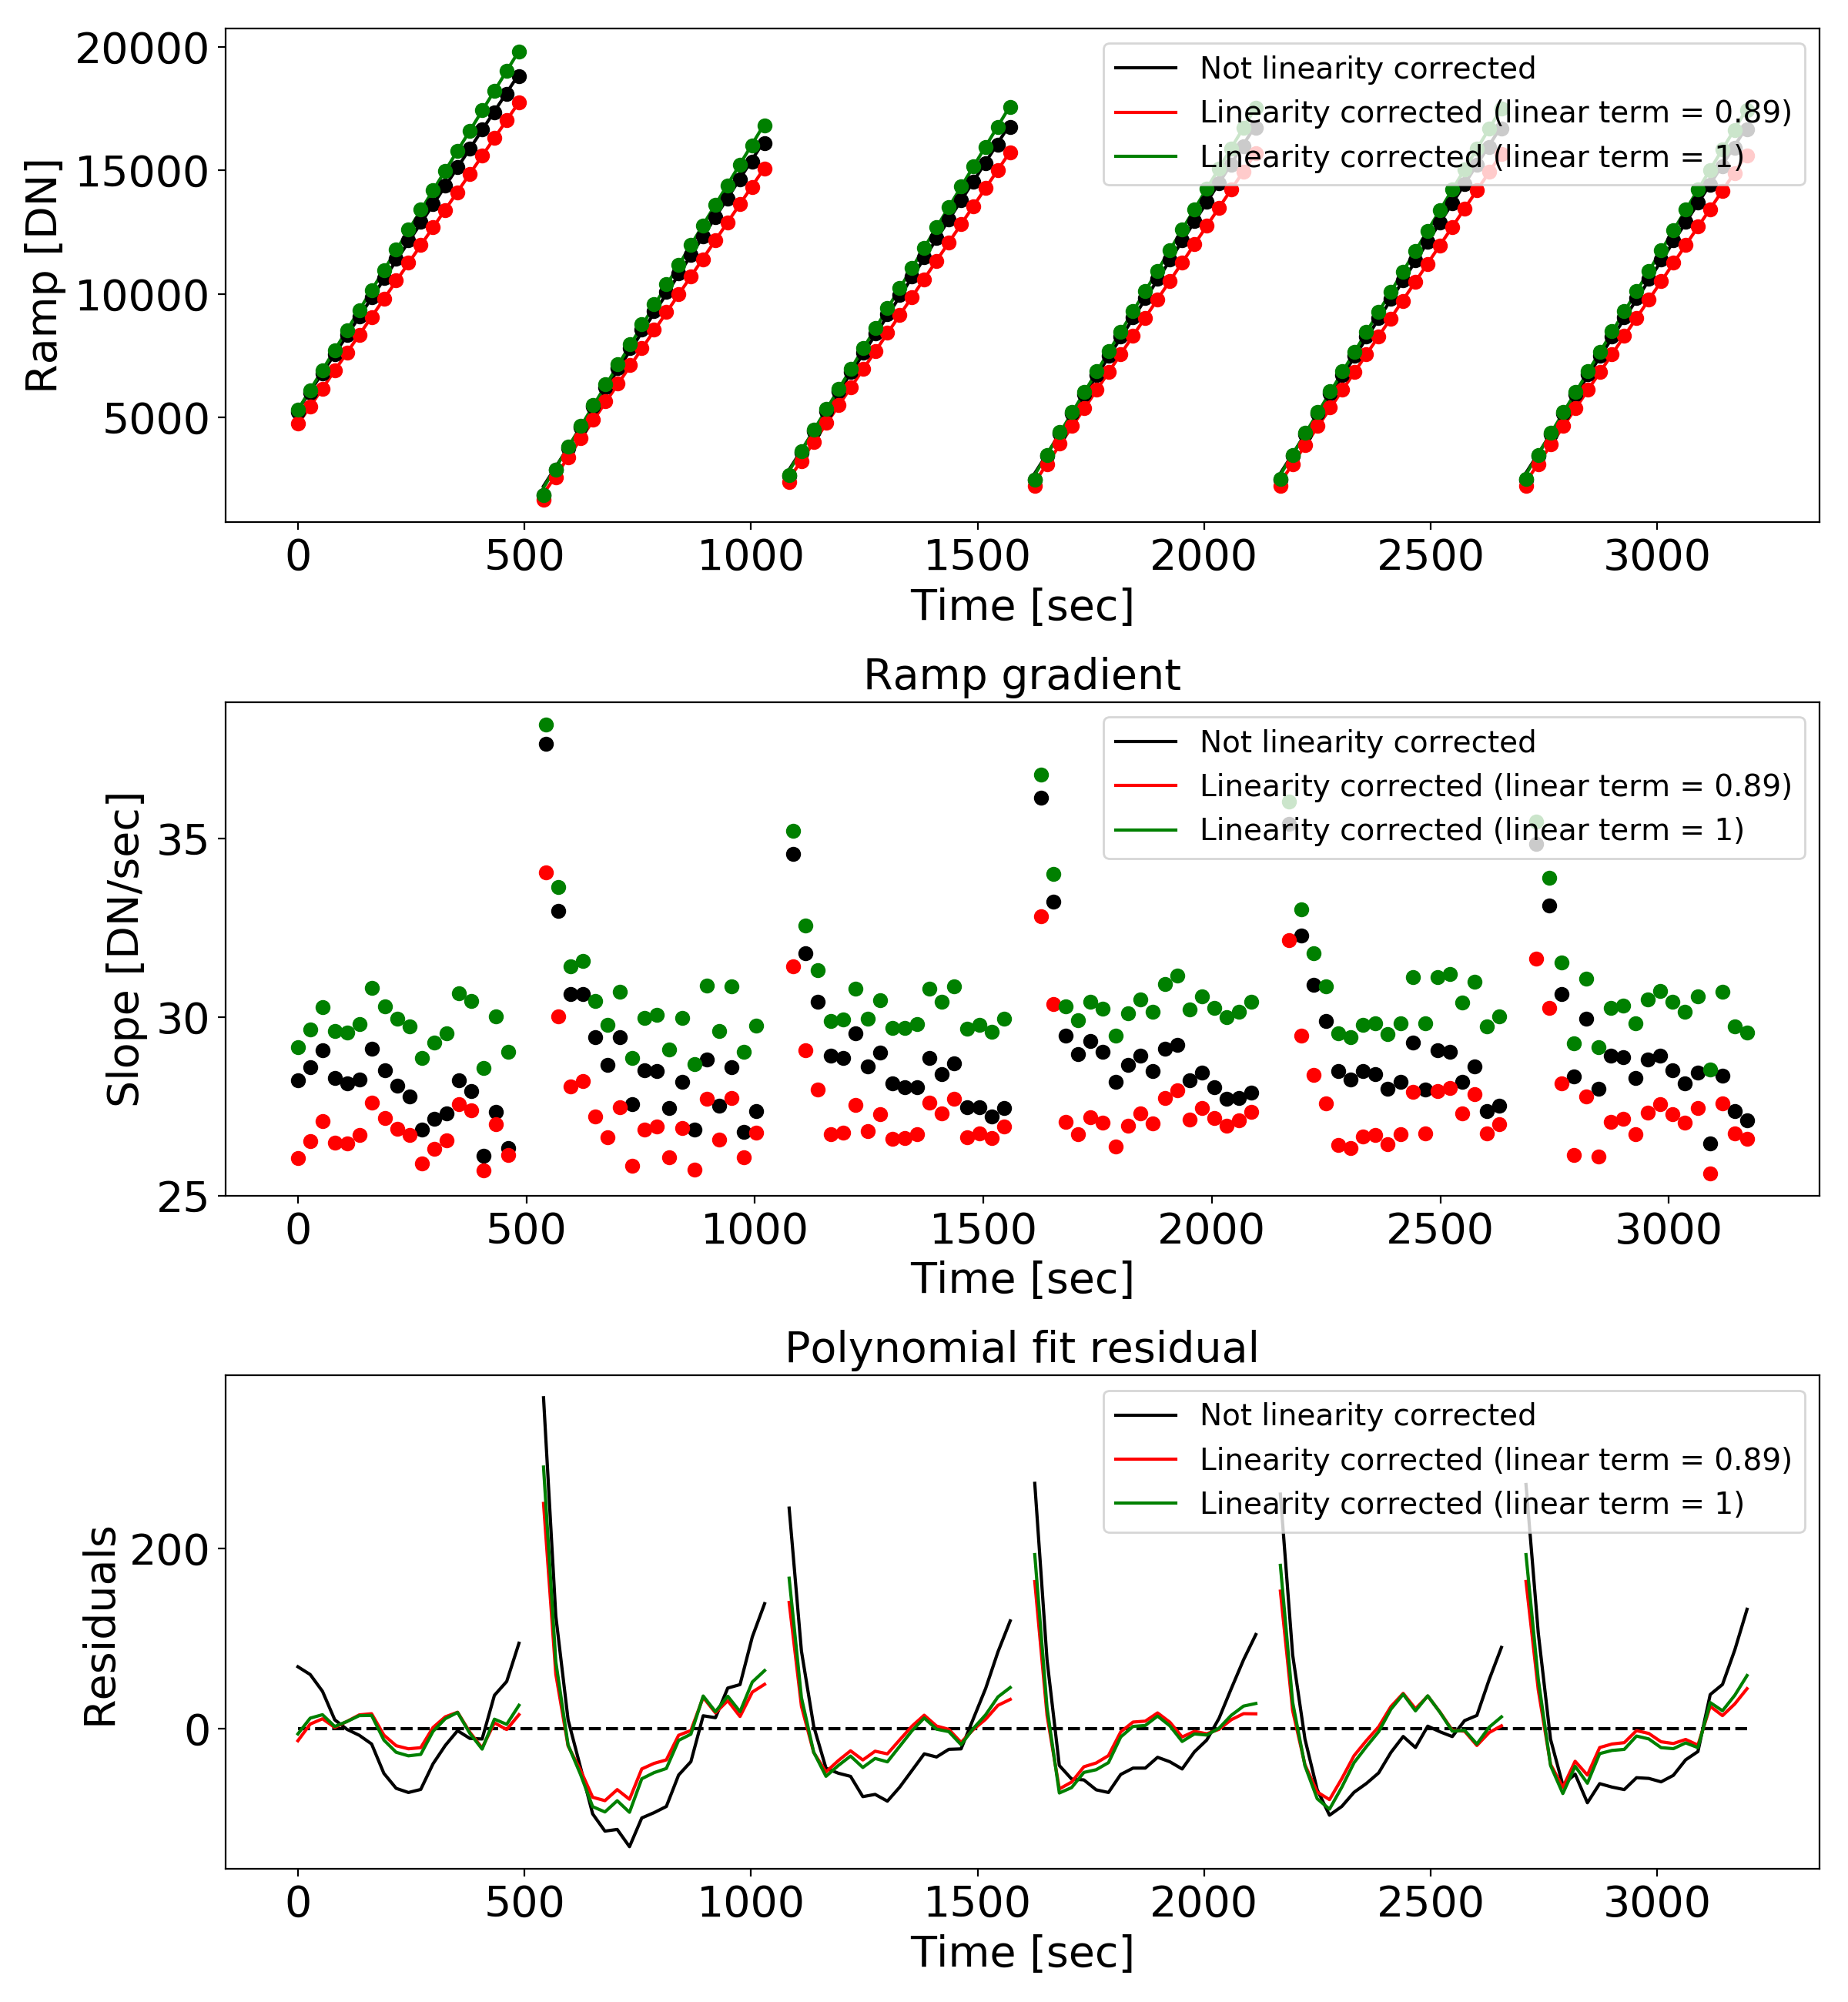

Determined slopes per integration (non-linearity uncorrected): [27.91, 28.73, 28.72, 28.92, 28.84, 28.78] DN/sec
Determined slopes per integration (non-linearity corrected, linear term = 0.89): [26.74, 27.08, 27.17, 27.35, 27.27, 27.21] DN/sec
Determined slopes per integration (non-linearity corrected, linear term = 1): [29.81, 30.24, 30.33, 30.53, 30.44, 30.38] DN/sec


In [16]:
ypos,xpos = 177,27
fig,axs = plt.subplots(3,1,figsize=(12,13))
slopes_noLinCorr,slopes_LinCorr1,slopes_LinCorr2,slopes_noLinCorr_minus_last_frame,slopes_LinCorr_minus_last_frame1,slopes_LinCorr_minus_last_frame2 = [],[],[],[],[],[]
for i in range(nints):
    xdata  = np.arange(sci_exp_ramp.shape[0])[i*ngroups:(i+1)*ngroups][:-1]*frame_delta_time
    ydata_noLinCorr  = sci_exp_ramp[i*ngroups:(i+1)*ngroups,ypos,xpos][:-1]
    ydata_LinCorr1    = sci_exp_ramp_linCorr_old[i*ngroups:(i+1)*ngroups,ypos,xpos][:-1]
    ydata_LinCorr2    = sci_exp_ramp_linCorr_new[i*ngroups:(i+1)*ngroups,ypos,xpos][:-1]
    
    n_poly = 1
    popt_noLinCorr = np.polyfit(xdata,ydata_noLinCorr,n_poly)
    popt_noLinCorr_minus_last_frame = np.polyfit(xdata[:-1],ydata_noLinCorr[:-1],n_poly)
    poly_noLinCorr = np.poly1d(popt_noLinCorr)
    
    popt_LinCorr1 = np.polyfit(xdata,ydata_LinCorr1,n_poly)
    popt_LinCorr_minus_last_frame1 = np.polyfit(xdata[:-1],ydata_LinCorr1[:-1],n_poly)
    poly_LinCorr1 = np.poly1d(popt_LinCorr1)
    
    popt_LinCorr2 = np.polyfit(xdata,ydata_LinCorr2,n_poly)
    popt_LinCorr_minus_last_frame2 = np.polyfit(xdata[:-1],ydata_LinCorr2[:-1],n_poly)
    poly_LinCorr2 = np.poly1d(popt_LinCorr2)
    
    slopes_noLinCorr.append(round(popt_noLinCorr[0],2))
    slopes_LinCorr1.append(round(popt_LinCorr1[0],2))
    slopes_LinCorr2.append(round(popt_LinCorr2[0],2))
    slopes_noLinCorr_minus_last_frame.append(round(popt_noLinCorr_minus_last_frame[0],2))
    slopes_LinCorr_minus_last_frame1.append(round(popt_LinCorr_minus_last_frame1[0],2))
    slopes_LinCorr_minus_last_frame2.append(round(popt_LinCorr_minus_last_frame2[0],2))
    
    residuals_noLinCorr = poly_noLinCorr(xdata)-ydata_noLinCorr
    residuals_LinCorr1   = poly_LinCorr1(xdata)-ydata_LinCorr1
    residuals_LinCorr2   = poly_LinCorr2(xdata)-ydata_LinCorr2

    axs[0].plot(xdata,poly_noLinCorr(xdata),'k')
    axs[0].plot(xdata,poly_LinCorr1(xdata),'r')
    axs[0].plot(xdata,poly_LinCorr2(xdata),'g')
    axs[0].plot(xdata,ydata_noLinCorr,'ko')
    axs[0].plot(xdata,ydata_LinCorr1,'ro')
    axs[0].plot(xdata,ydata_LinCorr2,'go')
    axs[0].set_xlabel('Time [sec]')
    axs[0].set_ylabel('Ramp [DN]')
    axs[1].set_title('Ramp gradient')
    axs[1].plot(xdata[:-1],np.diff(ydata_noLinCorr)/frame_delta_time,'ko')
    axs[1].plot(xdata[:-1],np.diff(ydata_LinCorr1)/frame_delta_time,'ro')
    axs[1].plot(xdata[:-1],np.diff(ydata_LinCorr2)/frame_delta_time,'go')
    axs[1].set_xlabel('Time [sec]')
    axs[1].set_ylabel('Slope [DN/sec]')
    axs[2].plot(xdata,residuals_noLinCorr,'k')
    axs[2].plot(xdata,residuals_LinCorr1,'r')
    axs[2].plot(xdata,residuals_LinCorr2,'g')
    axs[2].set_title('Polynomial fit residual')
    axs[2].set_xlabel('Time [sec]')
    axs[2].set_ylabel('Residuals')
legend_elements = [Line2D([0],[0],color='k',label='Not linearity corrected'),
                   Line2D([0],[0],color='r',label='Linearity corrected (linear term = {})'.format(round(linear_term,2) )),
                   Line2D([0],[0],color='g',label='Linearity corrected (linear term = 1)')]
for plot in range(3): axs[plot].legend(handles=legend_elements,loc='upper right')
axs[2].hlines(0,0,xdata[-1],linestyle='dashed')
plt.tight_layout()

print ('Determined slopes per integration (non-linearity uncorrected): {} DN/sec'.format(slopes_noLinCorr))
print ('Determined slopes per integration (non-linearity corrected, linear term = {}): {} DN/sec'.format(round(linear_term,2),slopes_LinCorr1))
print ('Determined slopes per integration (non-linearity corrected, linear term = {}): {} DN/sec'.format(1,slopes_LinCorr2))

**Load LVL2 data**

In [17]:
# Get data
sci_exp_slope_hdu_SW = fits.open(lvl2path+'FM1T00011282/MIRFM1T00011282_1_495_SE_2011-05-31T02h15m32_LVL2.fits')
sci_exp_slope_SW = sci_exp_slope_hdu_SW[0].data[0,:,:]
sci_exp_slope_hdu_LW = fits.open(lvl2path+'FM1T00011282/MIRFM1T00011282_1_494_SE_2011-05-31T02h15m02_LVL2.fits')
sci_exp_slope_LW = sci_exp_slope_hdu_LW[0].data[0,:,:]

# select data to use
sci_exp_slope_hdu = sci_exp_slope_hdu_SW
sci_exp_slope     = sci_exp_slope_SW

In [24]:
slopes = np.zeros(nints)
for i in range(nints):
    slopes[i] = round(sci_exp_slope_hdu[i].data[0,ypos,xpos],2)
    
print 'DHAS determined slopes: {}'.format(slopes)

DHAS determined slopes: [ 27.08  26.76  27.02  27.11  27.24  27.16]


**Plot slope image (average slope, from all integration ramps)**

<IPython.core.display.Javascript object>


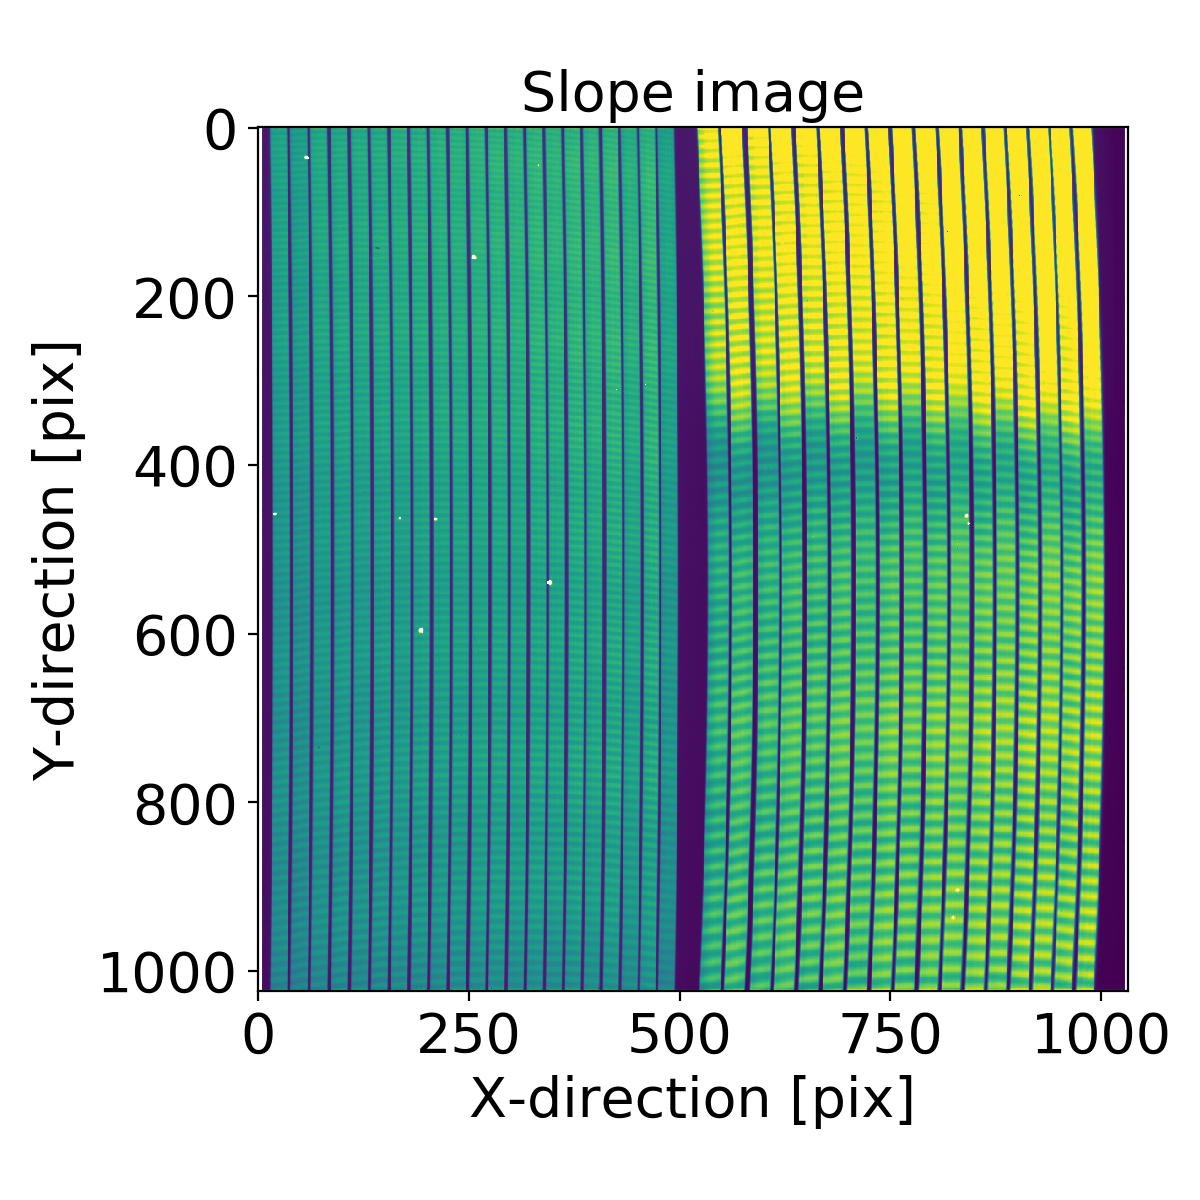

In [19]:
plt.figure(figsize=(6,6))
plt.title('Slope image')
plt.imshow(sci_exp_slope,vmin=0,vmax=50)
plt.xlabel('X-direction [pix]')
plt.ylabel('Y-direction [pix]')
plt.tight_layout()